In [1]:
import evaluator_prob as evaluator
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit import QuantumCircuit
from qiskit.transpiler.passes import NoiseAdaptiveLayout
from qcg.generators import gen_supremacy, gen_hwea
from qiskit import Aer, IBMQ, execute
from qiskit.converters import circuit_to_dag, dag_to_circuit
from scipy.stats import wasserstein_distance
from qiskit.providers.aer import noise
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram

circ = gen_supremacy(2,2,8,order='75601234')
num_shots = int(1e5)

c = ClassicalRegister(len(circ.qubits), 'c')
meas = QuantumCircuit(circ.qregs[0], c)
meas.barrier(circ.qubits)
meas.measure(circ.qubits,c)
qc = circ+meas

backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=num_shots)
result = job_sim.result()
noiseless_counts = result.get_counts(qc)
noiseless_prob = [noiseless_counts[state]/num_shots for state in noiseless_counts]

provider = IBMQ.load_account()
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates

result = execute(experiments=qc, backend=backend,noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates, shots=num_shots).result()
noisy_counts = result.get_counts(qc)
noisy_prob = [noisy_counts[i]/num_shots for i in noisy_counts]

dag = circuit_to_dag(circ)
noise_mapper = NoiseAdaptiveLayout(properties)
noise_mapper.run(dag)
initial_layout = noise_mapper.property_set['layout']

na_result = execute(experiments=qc, backend=backend,noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates, shots=num_shots,initial_layout=initial_layout).result()
na_counts = na_result.get_counts(qc)
na_prob = [na_counts[i]/num_shots for i in na_counts]

distance = wasserstein_distance(noiseless_prob,noisy_prob)
na_distance = wasserstein_distance(noiseless_prob,na_prob)
print('no NA:',distance,'NA:',na_distance,'ratio =',na_distance/distance)

no NA: 0.029013750000000005 NA: 0.021062499999999998 ratio = 0.7259489035371158


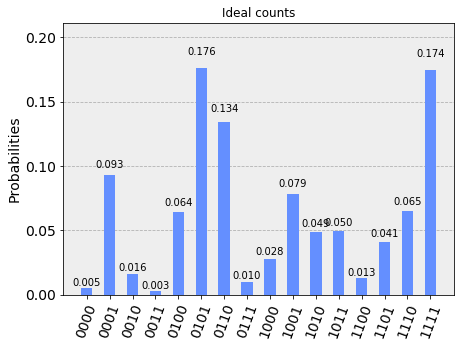

In [2]:
plot_histogram(noiseless_counts, title='Ideal counts')

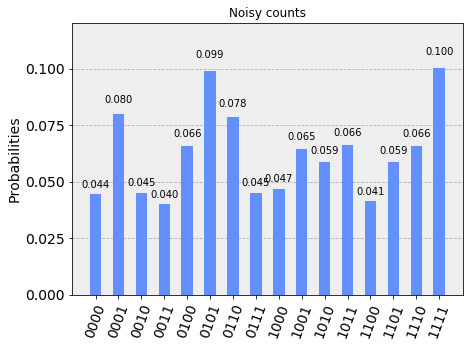

In [3]:
plot_histogram(noisy_counts, title='Noisy counts')

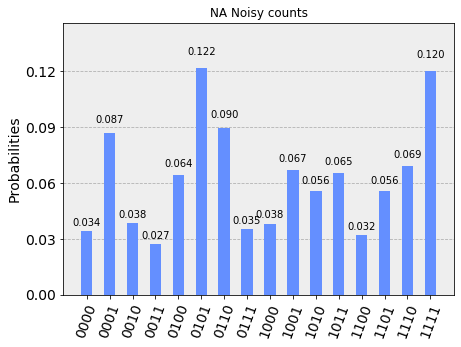

In [4]:
plot_histogram(na_counts, title='NA Noisy counts')